In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('dataset')

In [5]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


image_df = pd.concat([filepaths, labels], axis=1)


In [6]:
labels

0            COVID
1            COVID
2            COVID
3            COVID
4            COVID
           ...    
15148    Pneumonia
15149    Pneumonia
15150    Pneumonia
15151    Pneumonia
15152    Pneumonia
Name: Label, Length: 15153, dtype: object

In [7]:
image_df

,Filepath,Label
0,dataset\COVID\COVID-1.png,COVID
1,dataset\COVID\COVID-10.png,COVID
2,dataset\COVID\COVID-100.png,COVID
3,dataset\COVID\COVID-1000.png,COVID
4,dataset\COVID\COVID-1001.png,COVID
...,...,...
15148,dataset\Pneumonia\Viral Pneumonia-995.png,Pneumonia
15149,dataset\Pneumonia\Viral Pneumonia-996.png,Pneumonia
15150,dataset\Pneumonia\Viral Pneumonia-997.png,Pneumonia
15151,dataset\Pneumonia\Viral Pneumonia-998.png,Pneumonia


In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

C:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(64,64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)



test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(64,64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 8285 validated image filenames belonging to 2 classes.
Found 3452 validated image filenames belonging to 2 classes.


In [18]:
inputs = tf.keras.Input(shape=(64, 64, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)






x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=test_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
259/259 [==============================] - 93s 361ms/step - loss: 0.5465 - accuracy: 0.7380 - val_loss: 0.4876 - val_accuracy: 0.7378 - lr: 0.0010
Epoch 2/100
259/259 [==============================] - 44s 171ms/step - loss: 0.4638 - accuracy: 0.7785 - val_loss: 0.4318 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 3/100
259/259 [==============================] - 46s 177ms/step - loss: 0.4365 - accuracy: 0.7987 - val_loss: 0.4422 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 4/100
259/259 [==============================] - 44s 172ms/step - loss: 0.4184 - accuracy: 0.8081 - val_loss: 0.3962 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 5/100
259/259 [==============================] - 47s 180ms/step - loss: 0.4059 - accuracy: 0.8197 - val_loss: 0.3908 - val_accuracy: 0.8329 - lr: 0.0010
Epoch 6/100
259/259 [==============================] - 47s 180ms/step - loss: 0.3757 - accuracy: 0.8331 - val_loss: 0.3351 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 7/100
259/259 [=========================

In [28]:
evaluation = model.evaluate(test_images)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_images)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

108/108 [==============================] - 6s 55ms/step - loss: 0.1517 - accuracy: 0.9380
Test Accuracy: 93.80%
259/259 [==============================] - 23s 89ms/step - loss: 0.1503 - accuracy: 0.9416
Train Accuracy: 94.16%


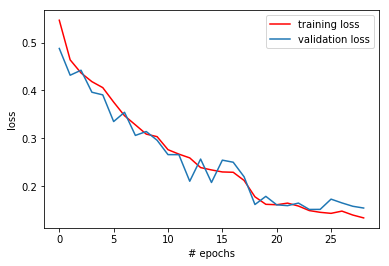

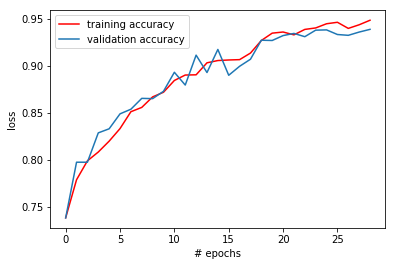

In [26]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

C:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


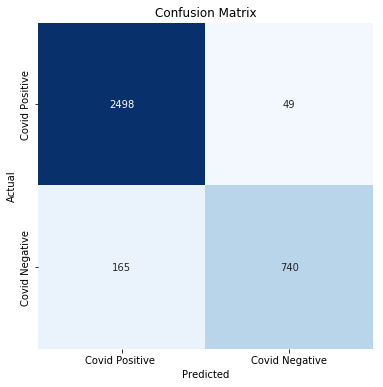

Classification Report:
----------------------
                  precision    recall  f1-score   support

Covid Positive        0.94      0.98      0.96      2547
 Covid Negative       0.94      0.82      0.87       905

      micro avg       0.94      0.94      0.94      3452
      macro avg       0.94      0.90      0.92      3452
   weighted avg       0.94      0.94      0.94      3452



In [24]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["Covid Positive ", "Covid Negative"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["Covid Positive ", "Covid Negative"])
plt.yticks(ticks=[0.5, 1.5], labels=["Covid Positive", "Covid Negative"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


In [25]:
from tensorflow.keras.models import load_model

model.save('xraymodel.h5')
from tensorflow.keras.models import load_model
 
# load model
# model = load_model('model_rcat_dog.h5')